In [195]:
# implementacion del paper theo2007
# mutual impedanci 2 coils arbitrary position

import pandas as pd
from scipy import integrate
from scipy import special
import numpy as np
import math
import matplotlib.pyplot as plt


# Examples

# Compute the double integral of x * y**2 over the box x ranging from 0 to 2 and y ranging from 0 to 1.

# from scipy import integrate
# f = lambda y, x: x*y**2
# integrate.dblquad(f, 0, 2, lambda x: 0, lambda x: 1)
#     (0.6666666666666667, 7.401486830834377e-15)


lim=500

mu0=1.26e-6

## tabla1
#driver
dr1=7.04e-3
dr2=12.2e-3
dl=5.04e-3
dN=544
dL0=5.55e-6
dn=dN/((dr2 -dr1)*dl)


#pickup
pr1=7.04e-3
pr2=12.40e-3
pl=5.04e-3
pN=556
pL0=5.84e-6
pn=pN/((pr2 -pr1)*pl)

#placa
sigma1=29.4e6
mu1=1
c1=2.47e-3


## config
# driver
dtita=0
dji=0
dx0=0
dy0=0
dl0=3.08e-3

# pickup
ptita=0
pji=math.radians(90)
px0=28e-3
py0=0
pl0=3.1e-3

# r1,r2,l,n,tita,ji,x0,y0,l0=coil

coil_d=[dr1,dr2,dl,dn,dtita,dji,dx0,dy0,dl0]
coil_p=[pr1,pr2,pl,pn,ptita,pji,px0,py0,pl0]


In [196]:


def a(u,v):
    return np.sqrt(u**2+ v**2)

def psi(u,v,tita):
    ps=u*np.sin(tita) + 1j*a(u,v)*np.cos(tita) 

    return ps

def R(u,v,w):
    a1=a(u,v)
    b1=np.sqrt(a1**2 + 1j*w*mu1*mu0*sigma1)/mu1 
    r=(a1-b1)/(a1+b1)  
    return r


def R(u,v,w):
    a0=a(u,v)
    b1=np.sqrt(a0**2 + 1j*w*mu1*mu0*sigma1)/mu1 
    b2=a0/mu1 
    ru=(b1+b2)*(a0-b1)+(b1-b2)*(a0+b1)*np.exp(-2*c1*b1)
    rd=(b1+b2)*(a0+b1)+(b1-b2)*(a0-b1)*np.exp(-2*c1*b1)
    return ru/rd



def H(uu,vv,coil):
    '''fast H'''
    r1,r2,l,n,tita,ji,x0,y0,l0=coil
    d=l0 + r2*np.sin(np.abs(tita)) + (l/2)*np.cos(tita)
    u=uu*np.cos(ji)+vv*np.sin(ji)
    v=-uu*np.sin(ji)+vv*np.cos(ji)
    h=1j*n*(M(psi(u,v,tita)*r1,psi(u,v,tita)*r2)*expsin(u,v,d,tita,l))/(psi(u,v,tita)**3)
    hp=h*np.exp(1j*uu*x0)*np.exp(1j*vv*y0)
    return hp

def M(z1,z2,klen=10):
    y=z2*special.iv(0,z2)-z1*special.iv(0,z1)-zum(klen,z1,z2)
    return y

def zum(klen,z1,z2):
    x=[]
    for k in range(0,klen):
        x.append((special.iv(2*k+1,z2)-special.iv(2*k+1,z1))*(-1)**k)
    return np.array(x).sum()

def expsin(u,v,d,tita,l):
    y=np.exp(1j*psi(u,v,tita)*l/2 - a(u,v)*d)-np.exp(-1j*psi(u,v,tita)*l/2 - a(u,v)*d)
    return y/2j

def int_re(u,v,coil_d,coil_p,w):
    return np.real(H(u,v,coil_d)*H(-u,-v,coil_p)*R(u,v,w)/a(u,v))

def int_im(u,v,coil_d,coil_p,w):
    return np.imag(H(u,v,coil_d)*H(-u,-v,coil_p)*R(u,v,w)/a(u,v))

def dZ(coil_d,coil_p,frec,lim=500):
    w=2*np.pi*frec

    f_im = lambda v, u: int_im(u,v,coil_d,coil_p,w)
    f_re = lambda v, u: int_re(u,v,coil_d,coil_p,w)
    
    dzp_im=2*w*mu0*integrate.dblquad(f_im, 1, lim, lambda u: 1, lambda u: lim)[0]
    dzn_im=2*w*mu0*integrate.dblquad(f_im, -lim, -1, lambda u: -lim, lambda u: -1)[0]

    dzp_re=2*w*mu0*integrate.dblquad(f_re, 1, lim, lambda u: 1, lambda u: lim)[0]
    dzn_re=2*w*mu0*integrate.dblquad(f_re, -lim, -1, lambda u: -lim, lambda u: -1)[0]
    
    return dzn_re+dzp_re+1j*dzn_im+1j*dzp_im

In [164]:
u=1
v=1
H(u,v,coil_d)*H(-u,-v,coil_p)*R(u,v,w)/a(u,v)

(-6550.533181130574-139.1401630934366j)

In [165]:
dZ(coil_d,coil_p,frec)

(-27.3656324008113-5.232338406760126j)

In [103]:
tlim=[]
for p in np.logspace(2,3,7):
    tlim.append(dZ(coil_d,coil_p,frec,lim=p))
    

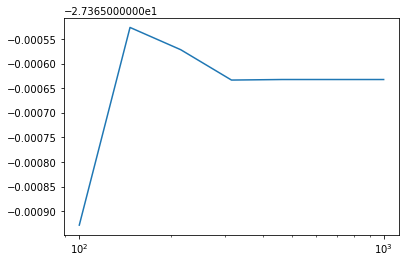

In [106]:
plt.semilogx(np.logspace(2,3,7),tlim)

In [197]:
fv=np.logspace(2,5,10)
dZs=[]
for f in fv:
    dZs.append(dZ(coil_d,coil_p,f))

In [198]:
dMs=np.array(dZs)/(1j*2*np.pi*fv)

In [191]:
dMs

array([-8.32752521e-03+0.04355376j, -4.42037107e-03+0.04563465j,
       -2.16358638e-03+0.0462732j , -1.05006754e-03+0.04643282j,
       -5.57291356e-04+0.04648741j, -3.66466500e-04+0.04655998j,
       -2.68695850e-04+0.0466745j , -1.84462524e-04+0.04676518j,
       -1.25923486e-04+0.04682429j, -8.59576232e-05+0.04686467j])

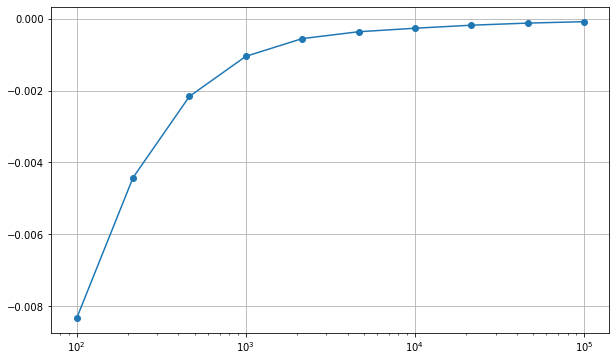

In [199]:
plt.figure(figsize=[10,6])
plt.semilogx(fv,dMs.real,'o-')
plt.grid(True)




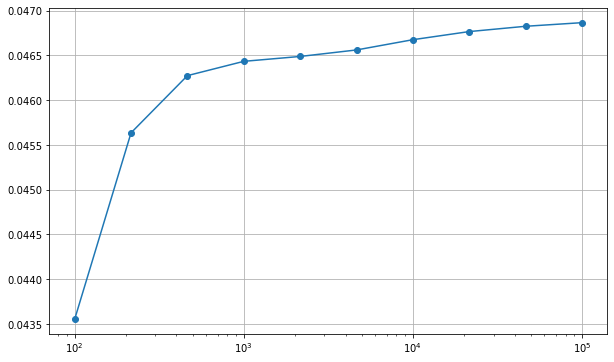

In [200]:
plt.figure(figsize=[10,6])
plt.semilogx(fv,dMs.imag,'o-')
plt.grid(True)

